# Cohorts in a Nutshell

> A cohort is a group of users who share the same starting point in time (e.g., all customers acquired in March 2023).

**Why use cohorts?**
  * They let you measure behavior over time relative to when users joined — not just in raw calendar months.
  * This makes it possible to compare how different “generations” of users behave.
  

**Cohort Index (Age)**:
* Instead of looking at absolute months (Jan, Feb, Mar), we align all cohorts by their age since joining (Month 0 = join, Month 1 = first month after, etc.).
* → This is what makes the analysis **“longitudinal” — you track groups over time**.

**What you learn (examples):**
* Retention: How many users are still active after 1, 2, 3 months?
* Monetization: Does revenue grow or shrink as customers age?
* Quality of cohorts: Are customers acquired later performing better or worse than earlier ones?

## Example
| Cohort (Join Month) | Month 0 | Month 1 | Month 2 |
|----------------------|---------|---------|---------|
| Jan 2023            | 100     | 60      | 40      |
| Feb 2023            | 120     | 70      | 55      |
| Mar 2023            |  90     | 50      | 35      |

## Cohort Heatmap

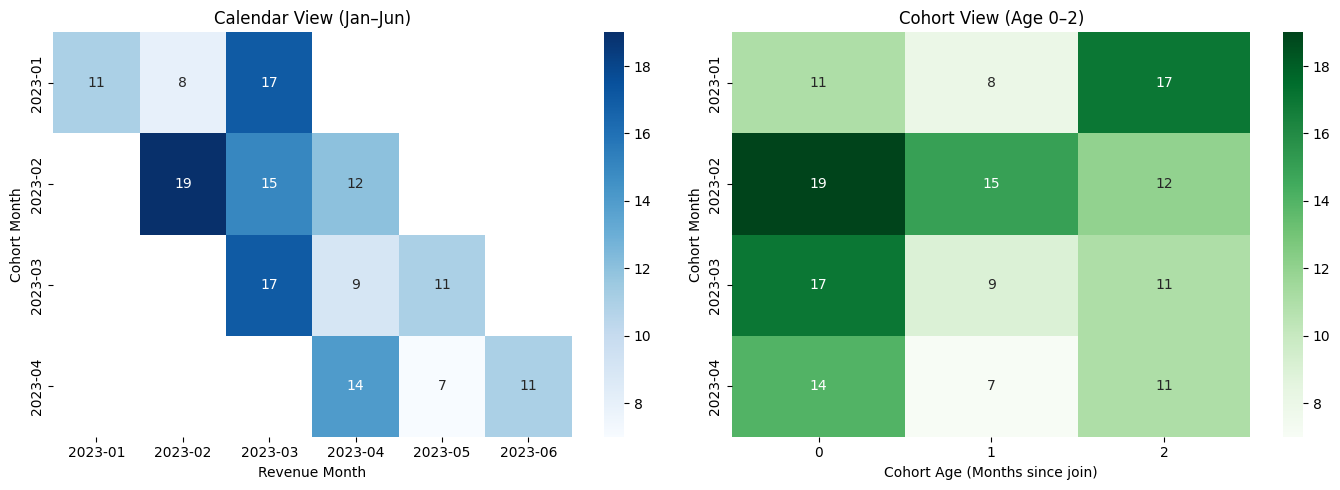

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Step 1: Create synthetic dataset
# -------------------------
np.random.seed(42)

users = [
    {"user_id": 101, "startdate": "2023-01-15"},
    {"user_id": 102, "startdate": "2023-02-03"},
    {"user_id": 103, "startdate": "2023-03-10"},
    {"user_id": 104, "startdate": "2023-04-01"},
]

records = []
for user in users:
    start = pd.to_datetime(user["startdate"])
    for month_offset in range(3):  # each user stays 3 months
        revenue_month = (start + pd.DateOffset(months=month_offset)).to_period("M")
        revenue = np.random.randint(5, 20)  # random revenue
        records.append({
            "user_id": user["user_id"],
            "startdate": start,
            "revenue_month": revenue_month,
            "revenue": revenue
        })

df = pd.DataFrame(records)

# -------------------------
# Step 2: Build cohorts
# -------------------------
df["cohort_month"] = df["startdate"].dt.to_period("M")
df["cohort_index"] = (
    (df["revenue_month"].dt.year - df["cohort_month"].dt.year) * 12
    + (df["revenue_month"].dt.month - df["cohort_month"].dt.month)
)

# -------------------------
# Step 3: Aggregate
# -------------------------
# Calendar view: pivot by actual revenue_month
calendar_pivot = df.pivot_table(
    index="cohort_month",
    columns="revenue_month",
    values="revenue",
    aggfunc="sum"
)

# Cohort view: pivot by cohort_index
cohort_pivot = df.pivot_table(
    index="cohort_month",
    columns="cohort_index",
    values="revenue",
    aggfunc="sum"
)

# -------------------------
# Step 4: Plot side by side
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(calendar_pivot, annot=True, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("Calendar View (Jan–Jun)")
axes[0].set_xlabel("Revenue Month")
axes[0].set_ylabel("Cohort Month")

sns.heatmap(cohort_pivot, annot=True, fmt=".0f", cmap="Greens", ax=axes[1])
axes[1].set_title("Cohort View (Age 0–2)")
axes[1].set_xlabel("Cohort Age (Months since join)")
axes[1].set_ylabel("Cohort Month")

plt.tight_layout()
plt.show()

## Explanation
Each user stays for 3 months max. That means:
* Jan cohort → Jan, Feb, Mar revenue.
* Feb cohort → Feb, Mar, Apr revenue.
* Mar cohort → Mar, Apr, May revenue.
* Apr cohort → Apr, May, Jun revenue.

Left heatmap - **Calendar view**:
* X-axis shows Jan → Jun 2023.
* Each cohort has revenue in its 3 active months.
* Later cohorts simply don’t exist in earlier months.

Right heatmap - **Cohort view**:
* X-axis shows Age 0 → Age 2.
* Each cohort is aligned at Age 0 (their join month), so you can compare cohorts directly.

## Normalized Cohort Heatmap

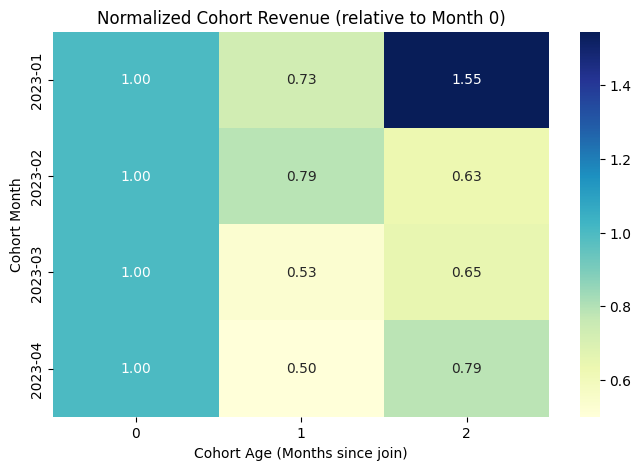

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Step 1: Create synthetic dataset
# -------------------------
np.random.seed(42)

users = [
    {"user_id": 101, "startdate": "2023-01-15"},
    {"user_id": 102, "startdate": "2023-02-03"},
    {"user_id": 103, "startdate": "2023-03-10"},
    {"user_id": 104, "startdate": "2023-04-01"},
]

records = []
for user in users:
    start = pd.to_datetime(user["startdate"])
    for month_offset in range(3):  # each user stays 3 months
        revenue_month = (start + pd.DateOffset(months=month_offset)).to_period("M")
        revenue = np.random.randint(5, 20)  # random revenue
        records.append({
            "user_id": user["user_id"],
            "startdate": start,
            "revenue_month": revenue_month,
            "revenue": revenue
        })

df = pd.DataFrame(records)

# -------------------------
# Step 2: Build cohorts
# -------------------------
df["cohort_month"] = df["startdate"].dt.to_period("M")
df["cohort_index"] = (
    (df["revenue_month"].dt.year - df["cohort_month"].dt.year) * 12
    + (df["revenue_month"].dt.month - df["cohort_month"].dt.month)
)

# -------------------------
# Step 3: Aggregate & Pivot
# -------------------------
cohort_pivot = df.pivot_table(
    index="cohort_month",
    columns="cohort_index",
    values="revenue",
    aggfunc="sum"
)

# -------------------------
# Step 4: Normalize by month 0
# -------------------------
normalized_pivot = cohort_pivot.divide(cohort_pivot[0], axis=0)

# -------------------------
# Step 5: Plot
# -------------------------
plt.figure(figsize=(8,5))
sns.heatmap(normalized_pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Normalized Cohort Revenue (relative to Month 0)")
plt.xlabel("Cohort Age (Months since join)")
plt.ylabel("Cohort Month")
plt.show()

## Explanation

**What you’ll see**
* Each row starts at 1.00 in Month 0 (the baseline revenue when the cohort joined).
* Following months show the percentage of that starting revenue retained.

**Why this is useful**
* Instead of asking “Did February earn more dollars than March?”, you ask: “Do February’s users keep spending longer than March’s users, relative to their starting level?”
* This removes the effect of different cohort sizes and isolates the retention pattern.
